Note that `pystan` has to be completely installed _before_ installing prophet

In [1]:
%pip install -q pystan==2.19.1.1

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q prophet

Note: you may need to restart the kernel to use updated packages.


Installation is dodgy. The first time it will fail. Just run the cell again after the first one fails

In [3]:
import prophet
import pandas as pd

In [12]:
class BQConnection:
    
    """Creates an authorised connection to BigQuery with which queries can be executed to fetch data into pandas"""
    def __init__(self, project_id: str):
        import pydata_google_auth

        self.project = project_id
        self.auth = pydata_google_auth.get_user_credentials(scopes=["https://www.googleapis.com/auth/bigquery"])
        
    def execute_query(self, query:str):
        response = pd.read_gbq(query=query, project_id=self.project, 
                               credentials=self.auth,
                               progress_bar_type="tqdm_notebook", 
                               use_bqstorage_api=True)
        return response
    


In [16]:
conn = BQConnection('uw-data-platform-prod')

In [58]:
query = """
SELECT custdateentered as date_joined, 
       custenddate as date_left, 1 as n_customers
FROM `uw-data-warehouse-prod.data_platform_bill.customer`
WHERE custdateentered > '2017-01-01'
"""

df_raw = conn.execute_query(query)

Downloading:   0%|          | 0/732381 [00:00<?, ?rows/s]

In [59]:
df_joiners = df_raw.groupby('date_joined')['n_customers'].count().sort_index().reset_index()
df_leavers = df_raw.groupby('date_left')['n_customers'].count().sort_index().reset_index()

In [60]:
prophet_df = df_joiners.copy()

## Prophet wants the columns to be callend in this way
prophet_df.columns = ['ds', 'y']

In [61]:
years = prophet_df.ds.dt.year.unique().tolist()
holiday_df = prophet.make_holidays.make_holidays_df(years, country='UK')

holiday_df['lower_window'] = -6 #How many days before the holiday we should expect an impact
holiday_df['upper_window'] = 2 #How many days after the holiday we should expect an impact

holiday_df.head()

,ds,holiday,lower_window,upper_window
0,2017-01-01,New Year's Day,-6,2
1,2017-01-02,New Year Holiday [Scotland],-6,2
2,2017-01-02,New Year's Day (Observed),-6,2
3,2017-01-03,New Year Holiday [Scotland] (Observed),-6,2
4,2017-03-17,St. Patrick's Day [Northern Ireland],-6,2


In [62]:
p = prophet.Prophet(yearly_seasonality=True, #Only if more than one yar of data
                    weekly_seasonality=True, #Only if not taking weekly rolling average
                    daily_seasonality=False, #Only if timestamps rather than dates
                    seasonality_mode='additive', #Most of the time 
                    holidays=holiday_df)

p.fit(prophet_df)

In [63]:
# Predictions for next quarter
future = p.make_future_dataframe(periods=90)
forecast = p.predict(future)

In [66]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Battle of the Boyne [Northern Ireland],Battle of the Boyne [Northern Ireland]_lower,Battle of the Boyne [Northern Ireland]_upper,Boxing Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-01-02,468.655207,78.854738,343.234607,468.655207,468.655207,0.0,0.0,0.0,0.0,...,36.103322,36.103322,36.103322,-97.074958,-97.074958,-97.074958,0.0,0.0,0.0,208.791449
1,2017-01-03,468.560401,144.106611,408.518946,468.560401,468.560401,0.0,0.0,0.0,0.0,...,56.126292,56.126292,56.126292,-95.612206,-95.612206,-95.612206,0.0,0.0,0.0,280.640499
2,2017-01-04,468.465594,237.899910,493.787861,468.465594,468.465594,0.0,0.0,0.0,0.0,...,12.553475,12.553475,12.553475,-93.169667,-93.169667,-93.169667,0.0,0.0,0.0,369.883542
3,2017-01-05,468.370788,283.618182,545.452505,468.370788,468.370788,0.0,0.0,0.0,0.0,...,23.355633,23.355633,23.355633,-89.739316,-89.739316,-89.739316,0.0,0.0,0.0,411.763742
4,2017-01-06,468.275981,329.855101,589.399941,468.275981,468.275981,0.0,0.0,0.0,0.0,...,79.713273,79.713273,79.713273,-85.333186,-85.333186,-85.333186,0.0,0.0,0.0,462.656067


In [64]:
prophet.plot.plot_plotly(p, forecast, changepoints=True)

In [65]:
prophet.plot.plot_components_plotly(p, forecast)

There seem to be spikes at the beginning of every month. Let's add them as a seasonality factor

In [86]:
months_beginnings = (pd.concat([prophet_df, forecast])
                     .loc[pd.concat([prophet_df, forecast]).ds.dt.day == 1, ['ds']]
                     .reset_index(drop=True))

months_beginnings['holiday'] = "Beginning of the month"
months_beginnings['lower_window'] = -6 #This might be due to partners rushing to get customers for incentive reasons
months_beginnings['upper_window'] = 1

In [87]:
p = prophet.Prophet(yearly_seasonality=True, #Only if more than one yar of data
                    weekly_seasonality=True, #Only if not taking weekly rolling average
                    daily_seasonality=False, #Only if timestamps rather than dates
                    seasonality_mode='additive', #Most of the time 
                    holidays=pd.concat([holiday_df, months_beginnings]))

p.fit(prophet_df)

In [88]:
future = p.make_future_dataframe(periods=90)
forecast = p.predict(future)

In [89]:
prophet.plot.plot_plotly(p, forecast, changepoints=True)

In [90]:
prophet.plot.plot_components_plotly(p, forecast)

Let's have a look at forecasts made at the beginning of the year

In [94]:
train = prophet_df.loc[prophet_df.ds < '2021-01-01'].copy()
valid = prophet_df.loc[prophet_df.ds >= '2021-01-01'].copy()

p = prophet.Prophet(yearly_seasonality=True, #Only if more than one yar of data
                    weekly_seasonality=True, #Only if not taking weekly rolling average
                    daily_seasonality=False, #Only if timestamps rather than dates
                    seasonality_mode='additive', #Most of the time 
                    holidays=pd.concat([holiday_df, months_beginnings]))

p.fit(train)

In [101]:
future = p.make_future_dataframe(periods=365, include_history=False)
forecast = p.predict(future)

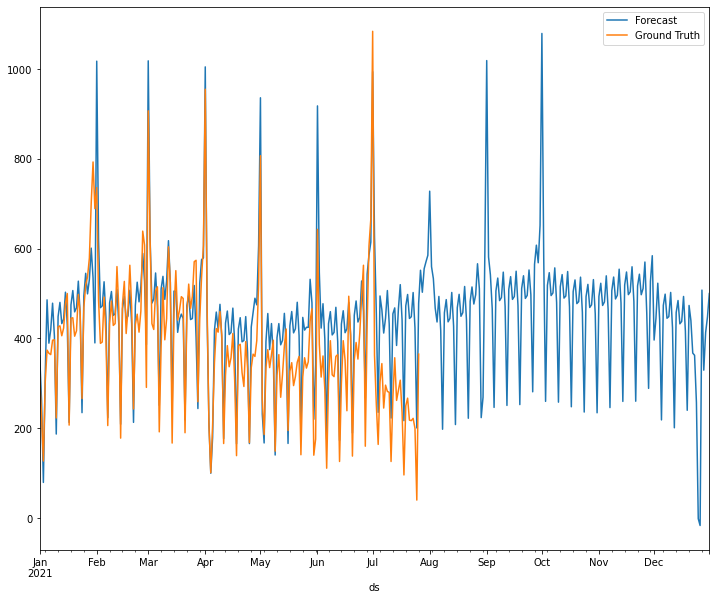

In [105]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 10))
forecast.set_index('ds').yhat.plot(label='Forecast')
valid.set_index('ds').y.plot(label='Ground Truth')
plt.legend();

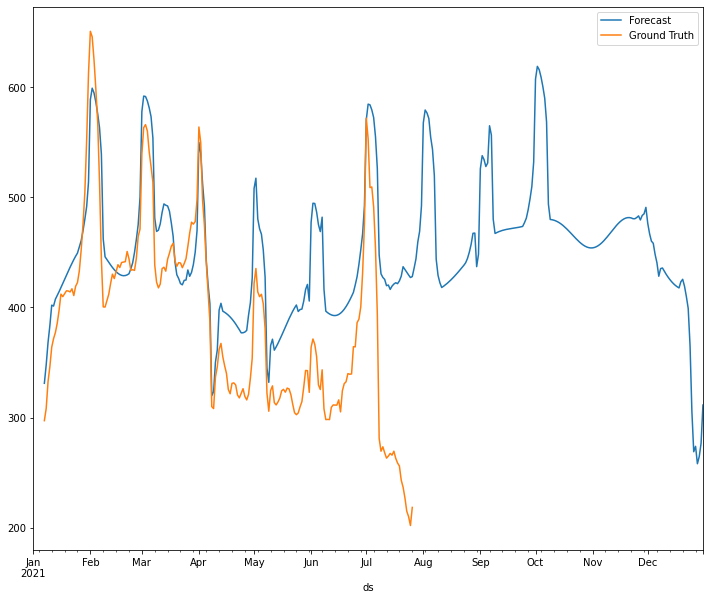

In [107]:
# Somooth with rolling means to highlight trends

fig, ax = plt.subplots(figsize=(12, 10))
forecast.set_index('ds').yhat.rolling(7).mean().plot(label='Forecast')
valid.set_index('ds').y.rolling(7).mean().plot(label='Ground Truth')
plt.legend();